# Коэффициент восстановления золота из золотосодержащей руды

# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Оглавление<a class='anchor' id='TOC'>
***

- [**I. Подготовка к исследованию**](#1)
    - [1) Импортируем библиотеки](#1_1)
    - [2) Объявим класс DataExplorer](#1_2)
    
    
- [**II. Подготовка данных**](#2)
    - [1) Прочитаем данные в переменные df_train, df_test, df_full](#2_1)
    - [2) Выведем первые пять строк каждой из таблиц, общую информацию](#2_2)
    - [3) Проверим, что эффективность обогащения рассчитана правильно](#2_3)
    - [4) Подготовим данные: установим в качестве индекса дату, заполним пропуски](#2_4)
    - [Вывод](#2_conclusion)
    
    
- [**III. Анализ данных**](#3)
    - [1) Проверим как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки](#3_1)
    - [2) Сравним распределения размеров гранул сырья на обучающей и тестовой выборках](#3_2)
    - [3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах](#3_3)
    
    
- [**IV. Модель**](#4)
    - [1) Инициализируем модели, создадим словарь для поиска наилучших параметров, разделим выборку на обучающую и тестовую в соотношении 75:25, выделим целевые признаки](#4_1)
    - [2) Обучим модель, посчитаем метрику SMAPE](#4_2)

# I. Подготовка к исследованию<a class='anchor' id='1'>
***

## 1) Импортируем библиотеки<a class='anchor' id='1_1'>

#### - установим модуль missingno для визуализации пропусков, что поможет впоследствии принять решение о способе заполнения пропусков

In [1]:
!pip install missingno

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msgn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error

from matplotlib import dates
import datetime

%matplotlib inline

[Оглавление](#TOC)

## 2) Объявим класс DataExplorer<a class='anchor' id='1_2'>

In [3]:
class DataExplorer:
      
    def histogram(self, data, n_bins, range_start, range_end, grid, cumulative=False, x_label = '', y_label = '', title = ''):
        
        """
        Простая гистограмма
        
        Пример:
        histogram(df, 100, 0, 150, True, 'Количество иксов', 'Количество игриков', 'Заголовок')
        
        data - датасет
        n_bins - количество корзин
        range_start - минимальный икс для корзины
        range_end - максимальный икс для корзины
        grid - рисовать сетку или нет (False / True)
        
        
        histogram(data, n_bins, range_start, range_end, grid, x_label = "", y_label = "", title = "")
        """
        
        # Создаем объект - график
        _, ax = plt.subplots()

        # Задаем параметры
        ax.hist(data, bins = n_bins, range = (range_start, range_end), cumulative = cumulative, color = '#4169E1')

        # Добавляем сетку
        if grid == True:
            ax.grid(color='grey', linestyle='-', linewidth=0.5)
        else:
            pass

        # Добавляем медиану, среднее и квартили
        ax.axvline(data.median(),linestyle = '--', color = '#FF1493', label = 'median')
        ax.axvline(data.mean(),linestyle = '--', color = 'orange', label = 'mean')
        ax.axvline(data.quantile(0.1),linestyle = '--', color = 'yellow', label = '1%')
        ax.axvline(data.quantile(0.99),linestyle = '--', color = 'yellow', label = '99%')
        ax.legend()
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.set_title(title)
        
        
    def scatterplot(self, x_data, y_data, x_label='', y_label='', title='', color = 'r', yscale_log=False, figsize = (8, 6)):
        
        """
        Простая диаграмма рассеивания
        
        Пример:
        scatterplot(df.real_target, df.predicted_target, x_label='Предсказанное моделью', y_label='Настоящий показатель', title='Диаграмма рассеивания')
        
        x_data - определяем иксы
        y_data - определяем игрики
              
        scatterplot(self, x_data, y_data, x_label='', y_label='', title='', color = 'r', yscale_log=False, figsize = (8, 6)):
        """
        
        # Создаем объект - график
        _, ax = plt.subplots(figsize = (8, 6))

        # Задаем параметры для графика, определяем размер (s), цвет и прозрачность точек на графике
        ax.scatter(x_data, y_data, s = 10, color = color, alpha = 0.75)

        if yscale_log == True:
            ax.set_yscale('log')

        # Создаем описание осей и заголовок для графика
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        
    def overlaid_histogram(self, data1, data2, n_bins = 0, data1_name='', data1_color='#539caf', data2_name='', data2_color='#7663b0', x_label='', y_label='', title=''):
        
        """
        Гистогорамма для двух выборок с одинаковыми границами бинов
        Пример:
        overlaid_histogram(df.one, df.two, n_bins = 80, data1_name='Первый датасет', data2_name='Второй датасет', x_label='Признак', y_label='Частота', title='Гистограмма')
        data1 - первый датасет
        data2 - второй датасет
        n_bins - количество корзин
        """
        
        
        # Устанавливаем границы для корзин так чтобы оба распределения на графике были соотносимы
        max_nbins = 10
        data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
        binwidth = (data_range[1] - data_range[0]) / max_nbins


        if n_bins == 0:
            bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)
        else: 
            bins = n_bins

        # Рисуем график
        _, ax = plt.subplots(figsize=(10,8))
        ax.hist(data1, bins = bins, color = data1_color, alpha = 0.65, label = data1_name)
        ax.hist(data2, bins = bins, color = data2_color, alpha = 0.65, label = data2_name)
        
        ax.axvline(data1.mean(),linestyle = '--', color = 'lime', label = 'mean for data 1')
                
        ax.axvline(data2.mean(),linestyle = '--', color = 'coral', label = 'mean for data 2')
                
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.set_title(title)
        ax.legend(loc = 'best')
        
        
    def corr_diagram(self, x):
                        
        """
        Диаграмма корреляции
        Пример:
        corr_diagram(self, data):
        """
                
        plt.figure(figsize=(12,10), dpi= 80)
        sns.heatmap(x.corr(), xticklabels=x.corr().columns, yticklabels=x.corr().columns, cmap='RdYlGn', center=0, annot=True)
        plt.title('Диаграмма корреляции', fontsize=22)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()
        
        
    def highlight_max(self, data, color='#00FF00'):
        
        """
        Подсвечивает максимумы в Series или DataFrame
        
        highlight_max(data)
        """
        
        attr = 'background-color: {}'.format(color)
        #remove % and cast to float
        data = data.replace('%','', regex=True).astype(float)
        data[data == 1] = None
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_max = (data == data.abs().max()) & (data !=1) 
            return [attr if v else '' for v in is_max]
        else:  # from .apply(axis=None)
            is_max = (data == data.abs().max()) & (data !=1) 
            return pd.DataFrame(np.where(is_max, attr, ''),
                                index=data.index, columns=data.columns)
    
    
    def highlight_sorted_corr(self, data, threshold, color='#00FF00'):
        
        """
        Подсвечивает значения выше определенного порога в Series или DataFrame (для одного столбца)
        
        highlight_sorted_corr(data, threshold)
        """

        attr = 'background-color: {}'.format(color)
        #remove % and cast to float
        data = data.replace('%','', regex=True).astype(float)
        data[data == 1] = None
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_max = (data > threshold) & (data !=1) 
            return [attr if v else '' for v in is_max]
        else:  # from .apply(axis=None)
            is_max = (data == data.abs().max()) & (data !=1) 
            return pd.DataFrame(np.where(is_max, attr, ''),
                                index=data.index, columns=data.columns)
        
        
    def lineplot(self, x_data, y_data, x_label="", y_label="", title=""):
        
                
        """
        Простой линейный график
        
        Пример:
        lineplot(df.some_x, df.some_y, x_label='Обозначения икс', y_label='Обозначения игрик', title='Заголовок')
        """
        
        
        # Создаем объект - график
        _, ax = plt.subplots(figsize=(8, 6))

        # Задаем параметры для линии: ширину (lw), цвет и прозрачность (alpha)
        ax.plot(x_data, y_data, lw = 2, color = '#539caf', alpha = 1)

        # Даем имена осям и заголовок для графика
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        
    def double_lineplot(self, x_data_1, y_data_1, x_data_2, y_data_2, x_label='', y_label='', title='', label_one='', label_two=''):
        
        """
        Простой двойной линейный график
        
        Пример:
        double_lineplot(df.some_x_1, df.some_y_1, df.some_x_2, df.some_y_2, x_label='Обозначения икс', y_label='Обозначения игрик', title='Заголовок', label_one='Линия 1', label_two='Линия 2'):
        """
        
        
        # Создаем объект - график
        _, ax = plt.subplots(figsize=(8, 6))

        # Задаем параметры для линии: ширину (lw), цвет и прозрачность (alpha)
        ax.plot(x_data_1, y_data_1, lw = 2, color = '#6400e4', alpha = 1, label = label_one)
        ax.plot(x_data_2, y_data_2, lw = 2, color = '#ffc740', alpha = 1, label = label_two)

        # Даем имена осям и заголовок для графика
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend(loc = 'best')
    
        
    def hexbin(self, data, x, y):
        
        """
        Простой график с сотами
        
        Пример:
        hexbin(df, df.true_target, df.predicted_target)
        """
        
        data.plot(x = x, y = y, kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)
        
        
    def bar_plotter(self, data):
        
        """
        Простой столбчатый график
        
        Пример:
        bar_plotter(data):
        """
        
        data.plot.bar(rot=0, figsize = (16, 5))
        
        
    def categorical_counter_plot(self, data, column, x = '', y = ''):
        
        """
        График для подсчета значений по категориям
        
        Пример:
        categorical_counter_plot(df, 'predicted', x = '10', y = '6'):
        """
        
        if x == '' or y == '':
            plt.rcParams["figure.figsize"] = (15, 10)
        else:
            plt.rcParams["figure.figsize"] = (x, y)
        
        order = data[column].value_counts().index
            
        ax = sns.countplot(data[column], order = order)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
        
        plt.xticks(rotation=90)
        
       
    def sns_scatterplot(self, data, x='', y='', hue='', size='', palette=''):
        
        """
        Диаграмма рассеивания seaborn
        
        Пример:
        sns_scatterplot(platform_scores_wo, 'user_score', 'total_sales', 'critic_score', 'year_of_release', True)
        """
        
        sns.set(style="whitegrid")

        f, ax = plt.subplots(figsize=(15, 10))
        
        if palette == True:
            sns.scatterplot(ax = ax, x=x, y=y, palette="ch:r=-.2,d=.3_r", 
                            hue=hue, size=size, sizes=(1, 200), linewidth=0, data=data)
        else:
            sns.scatterplot(ax = ax, x=x, y=y,
                            hue=hue, size=size, 
                            sizes=(1, 200), linewidth=0, data=data)
            
            
    def sns_catplot(self, data, x="", y="", hue=""):
        
        """
        Столбчатый график seaborn
        
        Пример:
        sns_catplot(df, x='platform', y='total_sales', hue='year')
        """
        
        
        sns.set(style='whitegrid')
        
        sns.catplot(x=x, y=y, hue=hue, kind='bar', errwidth=0, 
            data=data, height=5, aspect=3)
        
       
                
    def squared_ratio(self, df, grouper, title=''):
        
        """
        График соотношений
        
        Пример:
        squared_ratio(df, 'geography', 'Соотношение клиентов из различных стран')
        """
                
        df = df.groupby(grouper).size().reset_index(name='counts')
        labels = df.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
        sizes = df['counts'].values.tolist()
        colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

        plt.figure(figsize=(10,6), dpi= 80)
        squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

        plt.title(title)
        plt.axis('off')
        plt.show()
        
        
    def sorted_corr(self, data, attr):
        
        """
        Таблица с сортировкой корреляции конкретного аттрибута
        
        Пример:
        sorted_corr(df, 'money'):
        """
        
        correlated = pd.DataFrame(data.corr()[attr].sort_values(ascending = False))
        return correlated    
    
    
    def transformer(self, data, name, grouper, func):
        """
        
        transformer(df, 'some_stuff_to_change', 'grouper', np.mean()):
        
        data - датасет
        name - столбец в котором меняем значения
        grouper - столбец по которому группируем
        func - пременяемая функция mean, median и т.д.
        """
        name = name
        data.loc[data[name].isnull(), name] = data.groupby(grouper)[name].transform(func)
        
        
    def pr_curve(self, model, features_valid, target_valid):
        
        """
        PR-кривая
        
        Пример:
        pr_curve(model, features_valid, target_valid)
        """
        
        probabilities_valid = model.predict_proba(features_valid)
        precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

        plt.figure(figsize=(6, 6))
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Кривая Precision-Recall')
        plt.show()
        
    def roc_curve(self, model, features_valid, target_valid):
        
        """
        ROC-кривая
        
        Пример:
        roc_curve(model, features_valid, target_valid)
        """
        
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        
        fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
        
        plt.figure()
        plt.plot(fpr, tpr)
        
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlim(0,1)
        plt.ylim(0,1)
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        plt.title('ROC-кривая')
        
        plt.show()
        
    
    def metrics_plot(self, model, features_valid, target_valid):
        
        """
        Выводит на экран PR-кривую и ROC-кривую
        
        Пример:
        metrics_plot(model, features_valid, target_valid)
        """
                
        probabilities_valid = model.predict_proba(features_valid)
        precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
        fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])
            
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
        #fig, ax = plt.subplots(ncols=3)
        #fig.subplots_adjust(hspace=0.4, wspace=0.4)

        sns.lineplot(recall, precision, drawstyle='steps-post', ax=ax[0])
        ax[0].set_xlabel('Recall')
        ax[0].set_ylabel('Precision')
        ax[0].set_ylim([0.0, 1.05])
        ax[0].set_xlim([0.0, 1.0])
        ax[0].set_title('Кривая Precision-Recall')
        
        sns.lineplot(fpr, tpr, ax=ax[1])
        ax[1].plot([0, 1], [0, 1], linestyle='--')
        ax[1].set_xlim(0,1)
        ax[1].set_ylim(0,1)
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate')
        ax[1].set_title('ROC-кривая')
        
 
    def auc_roc(self, model, features_valid, target_valid):
        
        """
        Посчитывает значение ROC-AUC
        
        Пример:
        auc_roc(self, model, features_valid, target_valid)
        """
        
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        
        return auc_roc
            
    def upsample(self, features, target, repeat):
        
        """
        Дублирует объекты положительного класса и объединяет их с объектами отрицательного класса
        
        Пример:
        upsample(x_train, y_train, 4)
        """
        
        features_zeros = features[target == 0]
        features_ones = features[target == 1]
        target_zeros = target[target == 0]
        target_ones = target[target == 1]

        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

        features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
        
        return features_upsampled, target_upsampled
        
        
    def downsample(self, features, target, fraction):
        
        """
        Исключает долю объектов отрицательного класса и объединяет их с объектами положительного класса
        
        Пример:
        downsample(x_train, y_train, 0.5)
        """
        
        features_zeros = features[target == 0]
        features_ones = features[target == 1]
        target_zeros = target[target == 0]
        target_ones = target[target == 1]
        
        features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
        target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
        
        features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=42)
        
        return features_downsampled, target_downsampled
    
    
    def firstsight(self, data):
        
        """
        Возврашает пять первых, последних и случайных элементов датасета для дальнейшего вывода с помощью Display
        
        Пример:
        head, tail, sample = explorer.firstsight(df)
        """
        
        head = data.head(5)
        tail = data.tail(5)
        sample = data.tail(5)
        
        return head, tail, sample
        
        
    def smape(self, y_test, y_predict): 
        
        """
        Расcчитывает метрику SMAPE
        
        Пример:
        smape(y_test, y_predict)
        """
                
        y_test, y_predict = np.array(y_test), np.array(y_predict)
        return np.mean(np.abs(y_predict - y_test) / ((np.abs(y_test) + np.abs(y_predict) + 0.1**99)/2)) * 100
    
    
    def mape(self, y_test, y_predict):
        
        """
        Расcчитывает метрику MAPE
        
        Пример:
        mape(y_test, y_predict)
        """
                
        y_test, y_predict = np.array(y_test), np.array(y_predict)
        return np.median((np.abs((y_test - y_predict)) / (y_test + 0.1**100)) * 100)
    
    
    def df_split(self, data, features_drop, target, test_size, random_state):
        
        """
        Делит датасет по заданным параметрам
        
        Пример:
        x_train, x_test, y_train, y_test = explorer.df_split(df_geo_1, ['id', 'product'], 'product', 0.25, 42)
        """           
        
        feature = data.drop(features_drop, axis=1)
        target = data[target]
        x_train, x_test, y_train, y_test  = train_test_split(feature, target, test_size=test_size, random_state = random_state)
        return x_train, x_test, y_train, y_test
    
    
    def grid_search(self, model, param_grid, cv, x, y):
        
        """
        Поиск по сетке с заданными параметрами
        
        Пример:
        lr_geo_one = explorer.grid_search(lr, param_grid, 5, x_train, y_train)
        """
        
        grid_model = GridSearchCV(model, param_grid=param_grid, cv=cv, verbose=1, n_jobs=-1)
        grid_model.fit(x, y)
        best_estimator = grid_model.best_estimator_
        return best_estimator
    
    def color_styler(self, val):
        
        """
        Окрашивает зеленым числовые значения выше нуля, красным - ниже нуля
        
        Пример:
        
        df.style.applymap(color_styler)
        
        """
        
        color = 'green' if val > 0 else 'red'
        
        return 'color: %s' % color
        
        
    class Display(object):
        """
        Выводит HTML представление нескольких объектов
        
        Пример:
        Display(head, tail, sample)
        
        """
        template = """<div style="float: left; padding: 10px;">
        <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
        </div>"""
        def __init__(self, *args):
            self.args = args

        def _repr_html_(self):
            return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                             for a in self.args)

        def __repr__(self):
            return '\n\n'.join(a + '\n' + repr(eval(a))
                               for a in self.args)

#### Инициализируем класс

In [4]:
explorer = DataExplorer()

[Оглавление](#TOC)

# II. Подготовка данных<a class='anchor' id='2'>
***

## 1) Прочитаем данные в переменные df_train, df_test, df_full<a class='anchor' id='2_1'>

In [5]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date', parse_dates=['date'])
df_test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date', parse_dates=['date'])
df_full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date', parse_dates=['date'])

#### - принимая во внимание описание данных проверим форму полного датасета

In [6]:
df_full.shape

(22716, 86)

#### - поскольку в полном датасете 86 столбцов - а это максимальное число столбцов - расширим число отображаемых столбцов

In [7]:
pd.set_option('display.max_columns', 87)

[Оглавление](#TOC)

## 2) Выведем первые, последние и случайные пять строк каждого из датасетов, общую информацию<a class='anchor' id='2_2'>

### — обучающая выборка

In [8]:
head, tail, sample = explorer.firstsight(df_train)
explorer.Display('head', 'tail', 'sample')

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_c

#### Посчитаем число пропусков

In [10]:
df_train.isnull().sum().sort_values(ascending=False).head(15)

rougher.output.recovery                   2573
rougher.output.tail_ag                    2250
rougher.output.tail_sol                   2249
rougher.output.tail_au                    2249
secondary_cleaner.output.tail_sol         1986
rougher.input.floatbank11_xanthate        1904
final.output.recovery                     1521
primary_cleaner.input.sulfate             1307
primary_cleaner.input.depressant          1262
rougher.calculation.au_pb_ratio           1242
rougher.input.floatbank10_sulfate         1044
primary_cleaner.input.xanthate             985
primary_cleaner.output.concentrate_sol     636
rougher.input.floatbank11_sulfate          623
rougher.state.floatbank10_e_air            603
dtype: int64

In [11]:
df_train.isnull().sum().sort_values(ascending=False).tail(10)

primary_cleaner.state.floatbank8_d_air                39
primary_cleaner.state.floatbank8_c_air                38
primary_cleaner.state.floatbank8_a_level              33
rougher.calculation.floatbank11_sulfate_to_au_feed    27
primary_cleaner.state.floatbank8_b_level              27
rougher.calculation.floatbank10_sulfate_to_au_feed    27
rougher.calculation.sulfate_to_au_concentrate         27
primary_cleaner.state.floatbank8_d_level              27
primary_cleaner.state.floatbank8_c_level              27
primary_cleaner.input.feed_size                        0
dtype: int64

&#9889; **Вывод:** 
1. В обучающей выборке 16 860 строк.

2. В датасете множественные пропуски данных во всех столбцах, кроме primary_cleaner.input.feed_size.                    

3. Больше всего пропусков в столбцах с данными об обогащении чернового концентрата и отвальных хвостах:
    - rougher.output.recovery - 2573 из 16860 строк (15%)
    - rougher.output.tail_ag - 2250 из 16860 строк (13%)
    - rougher.output.tail_sol - 2249 из 16860 строк (13%)
    - rougher.output.tail_au - 2249 из 16860 строк (13%)
    
    
4. Визуально значения в столбцах близки к друг другу, что соответсвует описанию.

[Оглавление](#TOC)

### — тестовая выборка

In [12]:
head, tail, sample = explorer.firstsight(df_test)
explorer.Display('head', 'tail', 'sample')

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289

In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                    

#### Посчитаем число пропусков

In [14]:
df_test.isnull().sum().sort_values(ascending=False).head(10)

rougher.input.floatbank11_xanthate          353
primary_cleaner.input.sulfate               302
primary_cleaner.input.depressant            284
rougher.input.floatbank10_sulfate           257
primary_cleaner.input.xanthate              166
rougher.input.floatbank10_xanthate          123
rougher.input.feed_sol                       67
rougher.input.floatbank11_sulfate            55
rougher.input.feed_rate                      40
secondary_cleaner.state.floatbank3_a_air     34
dtype: int64

In [15]:
df_test.isnull().sum().sort_values(ascending=False).tail(10)

secondary_cleaner.state.floatbank3_b_air      16
secondary_cleaner.state.floatbank3_a_level    16
secondary_cleaner.state.floatbank2_b_level    16
secondary_cleaner.state.floatbank2_a_level    16
rougher.state.floatbank10_f_level             16
rougher.state.floatbank10_e_level             16
rougher.state.floatbank10_d_level             16
rougher.state.floatbank10_c_level             16
rougher.state.floatbank10_b_level             16
primary_cleaner.input.feed_size                0
dtype: int64

#### Поскольку в тестовой выборке 52 столбца вместо 86 в тестовой - выведем на экран столбцы, которые не попали в тестовую выборку

In [16]:
columns = []
for column in df_train.columns:
    if column not in df_test.columns:
        columns.append(column)
columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [17]:
features = df_test.columns

&#9889; **Вывод:** 
1. В обучающей выборке 5855 строк и 52 столбца, что на 34 столбца меньше, чем в обучающей выборке: **в тестовой выборке отсутствуют целевые признаки и рассчитанные на их основании показатели.**

2. Аналогично обучающей выборке в датасете множественные пропуски данных во всех столбцах, кроме primary_cleaner.input.feed_size и date.                    

3. Больше всего пропусков в столбцах с информацией об использованных в процессе химикатах:
    - rougher.input.floatbank11_xanthate - 353 из 5855 (6%),
    - primary_cleaner.input.sulfate - 302 из 5855 (5%)
    - primary_cleaner.input.depressant - 284 из 5855 (5%)
    - rougher.input.floatbank10_sulfate - 257 из 5855 (4%)
    - primary_cleaner.input.xanthate - 166 из 5855 (3%)
    - rougher.input.floatbank10_xanthate - 123 из 5855 (2%).
    

4. Значения в столбцах также близки к друг другу, что соответсвует описанию.

5. С учетом количества наблюдений в обучающей выборке (16 860) и тестовой выборке (5 855) - **датасет был разделен на обучающую и тестовую выборки в соотношении 74:26 (5855 / (16860 + 5855)).**

[Оглавление](#TOC)

### — исходные данные

In [18]:
head, tail, sample = explorer.firstsight(df_full)
explorer.Display('head', 'tail', 'sample')

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [19]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_c

#### Посчитаем число пропусков, проверим дубликаты

In [20]:
df_full.isnull().sum().sort_values(ascending=False).head(10)

rougher.output.recovery               3119
rougher.output.tail_ag                2737
rougher.output.tail_sol               2736
rougher.output.tail_au                2736
rougher.input.floatbank11_xanthate    2257
secondary_cleaner.output.tail_sol     2215
final.output.recovery                 1963
rougher.calculation.au_pb_ratio       1627
primary_cleaner.input.sulfate         1609
primary_cleaner.input.depressant      1546
dtype: int64

In [21]:
df_full.isnull().sum().sort_values(ascending=False).tail(10)

primary_cleaner.state.floatbank8_d_air                55
primary_cleaner.state.floatbank8_c_air                54
primary_cleaner.state.floatbank8_a_level              49
rougher.calculation.floatbank10_sulfate_to_au_feed    44
rougher.calculation.floatbank11_sulfate_to_au_feed    44
rougher.calculation.sulfate_to_au_concentrate         44
primary_cleaner.state.floatbank8_d_level              43
primary_cleaner.state.floatbank8_b_level              43
primary_cleaner.state.floatbank8_c_level              43
primary_cleaner.input.feed_size                        0
dtype: int64

In [22]:
df_full.duplicated().sum()

22

In [23]:
sum(df_full.isna().sum())

36587

In [24]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_c

&#9889; **Вывод:** 
1. В полном датасете 22 716 строк, цифровые значения показателей близки, дубликатов нет, требуется заполнение пропусков.

2. Поскольку тестовая и обучающие выборки получены в результате разделения полного датасета, ожидаемо, пропуски есть и в полном датасете, кроме столбца primary_cleaner.input.feed_size.                    

3. По тем же причинам характер пропусков полного датасета соответсвует характеру пропусков на обучающей выборке. Больше всего пропусков в столбцах с данными об обогащении чернового концентрата и отвальных хвостах:
    - rougher.output.recovery - 3119 из 22716 (14%)
    - rougher.output.tail_ag - 2737 из 22716 (12%)
    - rougher.output.tail_sol - 2736 из 22716 (12%)
    - rougher.output.tail_au - 2736 из 22716 (12%)
    
    
4. Всего в датасете 36 587 пропущенных значения из 1 976 292‬ - 2% от датасета (36 587 / (22716 x 87)).

[Оглавление](#TOC)

## 3) Проверим, что эффективность обогащения рассчитана правильно: вычислим на обучающей выборке для признака rougher.output.recovery<a class='anchor' id='2_3'>

#### - принимая во внимание пропуски в датасете, с учетом цели проверить правильность расчета - подготовим датасет без пропусков

In [25]:
df_recovery_validation = df_train.dropna()

#### - объявим функцию recovery_calculation, которая подсчитает эффективность обогащения по формуле

In [26]:
def recovery_calculation(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    
    return (c * (f-t) / (f * (c-t)+0.1**100)) * 100

#### - применим функцию к обучающему датасету, результат сохраним в столбце rougher_recovery

In [27]:
df_recovery_validation['rougher_recovery'] = df_train.apply(recovery_calculation, axis=1)

#### - выведем на экран первые пять строк с настоящими и расчетными показателями признака

In [28]:
df_recovery_validation[['rougher.output.recovery', 'rougher_recovery']].head(5)

,rougher.output.recovery,rougher_recovery
date,,
2016-01-15 00:00:00,87.107763,87.107763
2016-01-15 01:00:00,86.843261,86.843261
2016-01-15 02:00:00,86.842308,86.842308
2016-01-15 03:00:00,87.226430,87.226430
2016-01-15 04:00:00,86.688794,86.688794


#### - подсчитаем mean absolute error между показателями признака и расчетами

In [29]:
mean_absolute_error(df_recovery_validation['rougher.output.recovery'], df_recovery_validation['rougher_recovery'])

9.739730529255835e-15

&#9889; **Вывод:** 
1. Для проверки правильности расчета показателя эффективности обогащения был подготовлен датасет без пропусков.

2. Эффективность обогащения расчитана для чернового концентрата в соответствии с формулой, представленной вместе с описанием данных. В знаменатель добавлено число - 0.1 в степени 100 - для избежания деления на ноль.

3. **Значения между настоящими и расчетными показателями признака индентичны, значение MAE стремится к нулю: 9.555596961987514e-15**. Причина по которой МАЕ не равно нулю - это добавленный в знаменатель -0.1 в степени 100.

4. Исходя из представленных данных, с учетом отброшенных пропущенных значений, можно сделать вывод о том, что **эффективность обогащения в датасете рассчитана в соответствии с представленной вместе с описанием данных формулой.**

[Оглавление](#TOC)

## 4) Подготовим данные: заполним пропуски<a class='anchor' id='2_4'>

#### - визуализируем пропуски с помощью Missingno

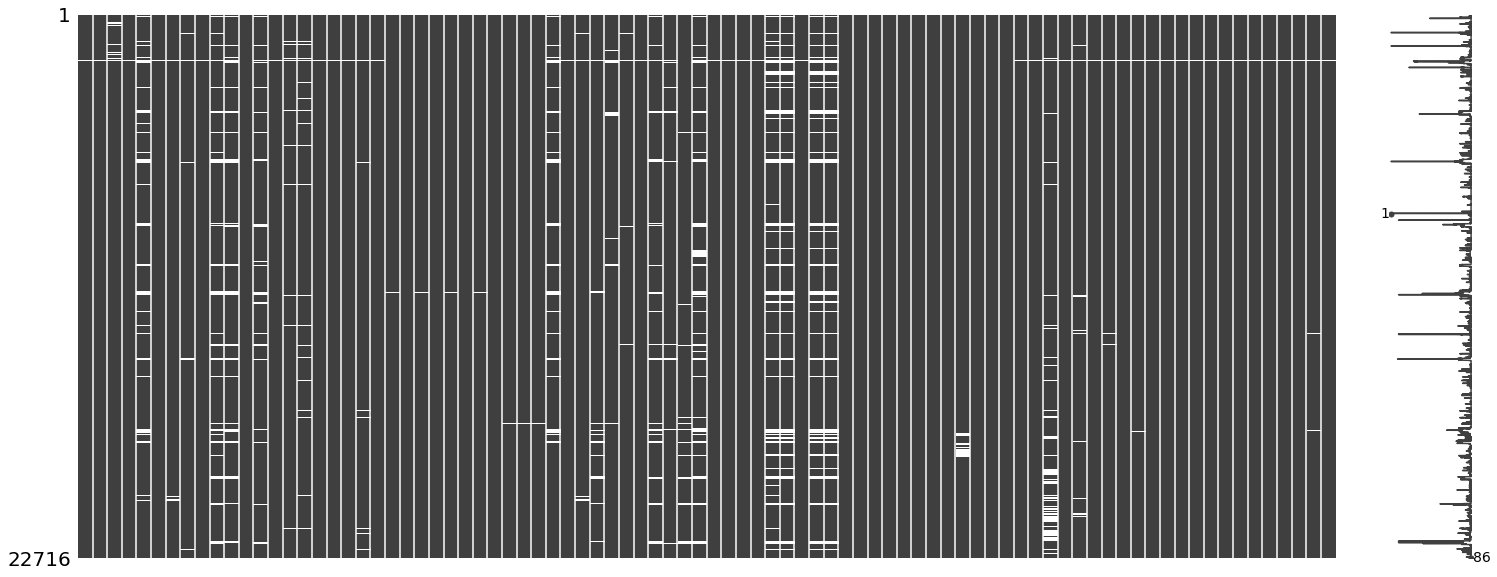

In [30]:
msgn.matrix(df_full)

Визуально видно, что пропуски в столбцах распределены по всему датасету. Поскольку возможность обратиться к поставщику данных отсутствует, расчетным методом восполнить пропуски не представляется воможным, а заполнение статистическими методами некорректно в силу особенностей данных - **рационально избавиться удалить строки с попусками**

#### - удалим строки с пропусками

In [31]:
df_full.shape

(22716, 86)

In [32]:
df_full.dropna(inplace=True)

In [33]:
df_full.shape

(16094, 86)

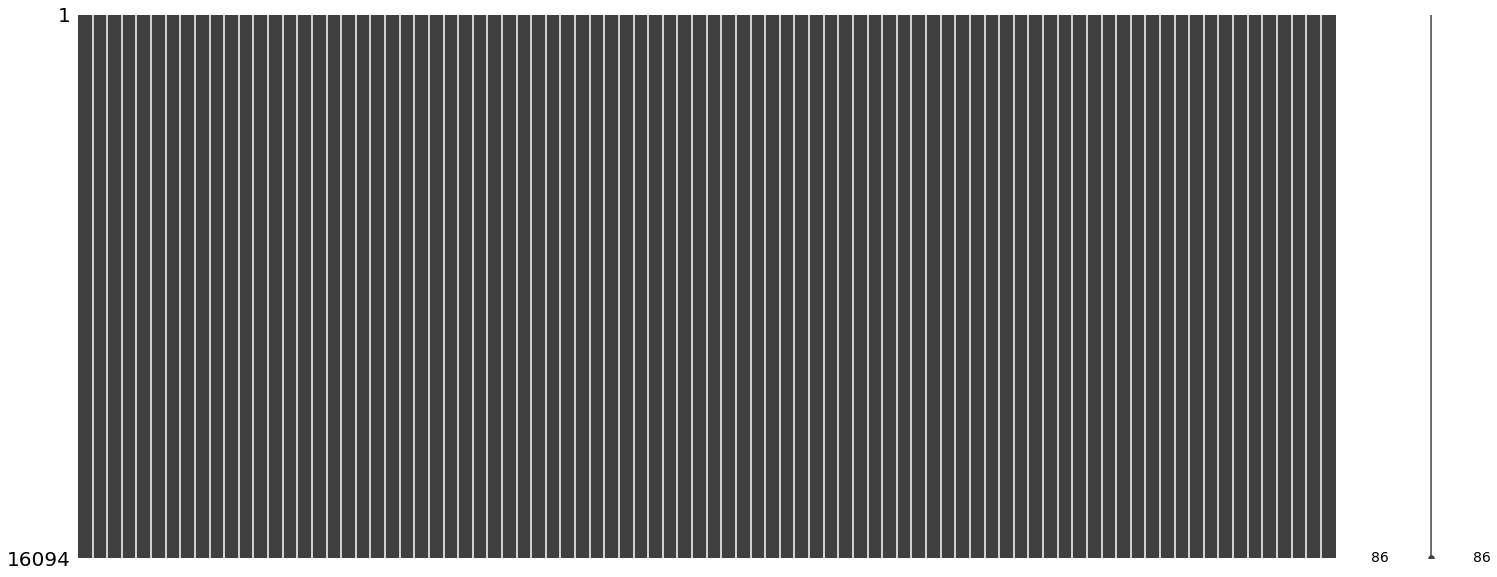

In [34]:
msgn.matrix(df_full)

&#9889; **Вывод:** удалены 6 622 (29%) строки из 22 716 строк. Осталось - 16 094 (71% от первоначального размер датасета)

[Оглавление](#TOC)

## Вывод<a class='anchor' id='2_conclusion'>

Исходя из представленных данных и описаний данных, можно сделать следующие выводы:

1.	Для исследования представлены три датасета с параметрами добычи и очистки золота методом флотации: 

    - исходный датасет с 22 716 наблюдениями,
    - обучающий датасет с 16 860 наблюдениями,
    - тестовый датасет с 5855 наблюдениями.
    
    
2.	Обучающий и тестовый датасеты получены путем разделения исходного датасета в соотношении 74:26 (5855 / (16860 + 5855)).

3.	Важной особенностью тестового датасета является отсутствие в нем как целевых признаков, так и признаков, которые станут известны только в результате очистки продукта.

4.	В представленных данных нет существенных проблем с типом данных, нет полных дубликатов.

5.	Больше всего пропусков в столбцах с данными об обогащении чернового концентрата и отвальных хвостах:
    - rougher.output.recovery - 3119 из 22716 (14%),
    - rougher.output.tail_ag - 2737 из 22716 (12%),
    - rougher.output.tail_sol - 2736 из 22716 (12%),
    - rougher.output.tail_au - 2736 из 22716 (12%).
    
    
6.	Всего в датасете 36 587 пропущенных значения из 1 976 292‬ - 2% от датасета (36 587 / (22716 x 87)).

7.	Эффективность обогащения рассчитана для чернового концентрата была проверена в соответствии с формулой, представленной вместе с описанием данных. Значения между настоящими и расчетными показателями признака индентичны, значение MAE стремится к нулю: 9.555596961987514e-15. Причина, по которой МАЕ не равно нулю — это добавленный в знаменатель -0.1 в степени 100 для избегания деления на ноль.

8.	Поскольку обучающий и тестовый датасеты получены путем разделения исходного датасета – принято решение подготовить новую тестовую выборку на основании исходного датасета.

9.	Поскольку возможность обратиться к поставщику данных отсутствует, расчетным методом восполнить пропуски не представляется воможным, а заполнение статистическими методами некорректно в силу особенности данных - строки с пропусками были удалены: 6 622 (29%) строки из 22 716 строк.

[Оглавление](#TOC)

# III. Анализ данных<a class='anchor' id='3'>
***

## 1) Проверим как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки<a class='anchor' id='3_1'>

#### - отберем необходимые признаки

In [35]:
concetratons = [i for i in df_full if '.output.concentrate_' in i and 'sol' not in i]

#### - соберем сводную таблицу

In [36]:
df_temp = df_full[concetratons]
df_temp = pd.DataFrame(df_temp.unstack())
df_temp.reset_index(inplace=True)
df_temp.columns = ['stage', 'misc', 'concentration']
df_concentration = df_temp[['stage', 'concentration']]
df_concentration_pivot = df_concentration.pivot_table(index='stage')
df_concentration_pivot

,concentration
stage,
final.output.concentrate_ag,5.190976
final.output.concentrate_au,44.307437
final.output.concentrate_pb,9.997593
primary_cleaner.output.concentrate_ag,8.674853
primary_cleaner.output.concentrate_au,32.065559
primary_cleaner.output.concentrate_pb,9.884018
rougher.output.concentrate_ag,12.084945
rougher.output.concentrate_au,20.052152
rougher.output.concentrate_pb,7.553095


#### - присвоим показатели по каждому из элементов переменным

In [37]:
au=df_concentration_pivot.loc[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
ag=df_concentration_pivot.loc[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
pb=df_concentration_pivot.loc[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]

#### - визуализируем результат

[Text(0.5, 1.0, 'Концентрация свинца')]

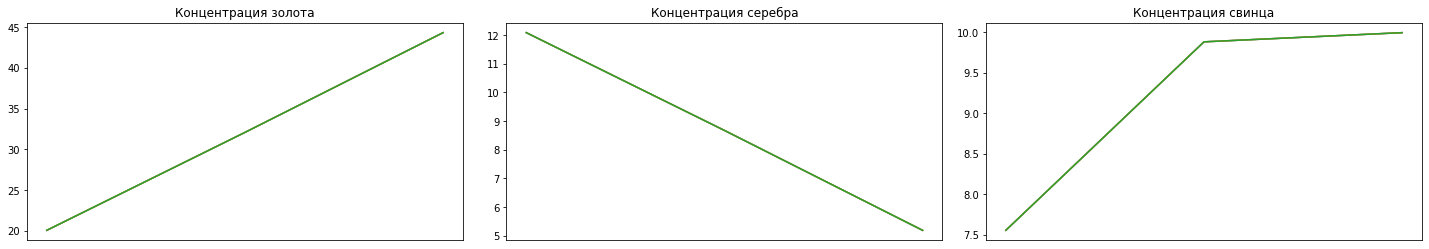

In [38]:
f, axes = plt.subplots(1, 3, figsize=(25, 4))
f.subplots_adjust(hspace=0.4, wspace=0.1)

for i in range(3):
    axes[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    axes[0].plot(au)
    axes[1].plot(ag)
    axes[2].plot(pb)
    
axes[0].set(title='Концентрация золота')
axes[1].set(title='Концентрация серебра')
axes[2].set(title='Концентрация свинца')

&#9889; **Вывод:** концентрация металлов (Au, Ag, Pb) на различных этапах очистки меняется по-разному:

    - золото (au) показывает положительный линейный рост,
    - серебро (ag) показывает отрицательный линейный рост,
    - концентрация свинца (pb) показывает резкий линейный рост от чернового концентрата до первого этама очистки, а затем незначительный к финальному концентрату.

[Оглавление](#TOC)

## 2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках<a class='anchor' id='3_2'>

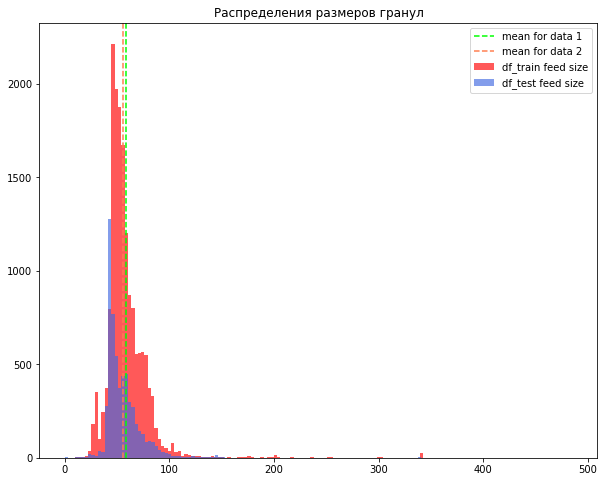

In [39]:
explorer.overlaid_histogram(df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size'], 150, 
                            data1_name='df_train feed size', data1_color='red',
                            data2_name='df_test feed size', data2_color='royalblue',
                            title='Распределения размеров гранул')

&#9889; **Вывод:** распределения размеров гранул сырья на обучающей и тестовой выборках различаются незначительно.

[Оглавление](#TOC)

## 3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах<a class='anchor' id='3_3'>

#### - исходя из содержания задачи затруднительно установить о каких именно веществах идет речь. Исходя из контекства поставленных задач - отберем cтолбцы - output и input, вещества - sol, au, pb, ag.

In [40]:
output_check = [i for i in df_full.columns if 'concentrate_' in i]

In [41]:
input_check = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']

#### - посчитаем концентрацию

In [42]:
df_output_concentration_check = df_full[output_check]
df_input_concentration_check = df_full[input_check]

In [43]:
df_output_concentration_check['output_check'] = df_output_concentration_check.apply(np.sum, axis=1)
df_input_concentration_check['input_check'] = df_input_concentration_check.apply(np.sum, axis=1)

#### - визуализируем результат

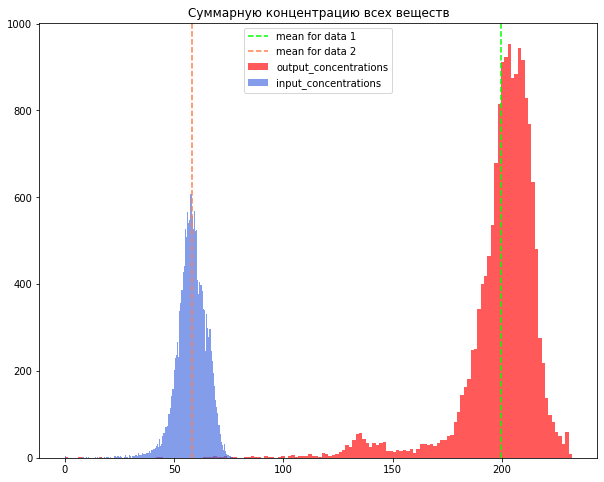

In [44]:
explorer.overlaid_histogram(df_output_concentration_check['output_check'], df_input_concentration_check['input_check'], 150, 
                            data1_name='output_concentrations', data1_color='red',
                            data2_name='input_concentrations', data2_color='royalblue',
                            title='Cуммарную концентрацию всех веществ')

Длинный хвост, и четыре пика в суммарной концентрации веществ в финале, хвост в суммарной концентрации при подаче вещества. Очевидно, в датасете есть выбросы. Построим боксплоты.

#### - боксплот для концентрации на подаче

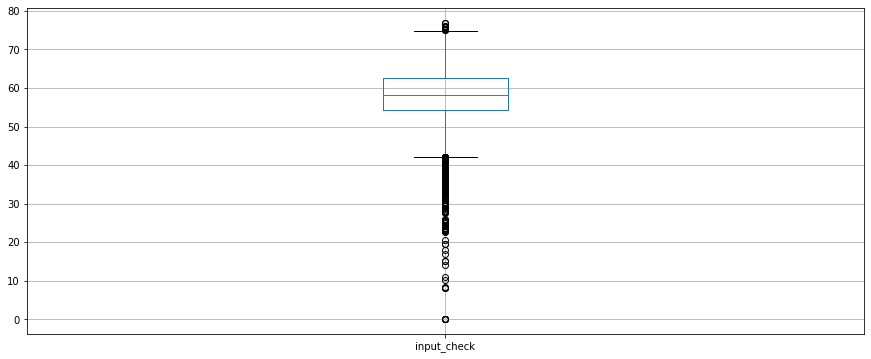

In [45]:
df_input_concentration_check.boxplot('input_check', figsize=(15, 6))

Верхний ус в районе 75, нижний ус в районе 42. Множественные выбросы.

#### - боксплот для концентрации при финальной очистке

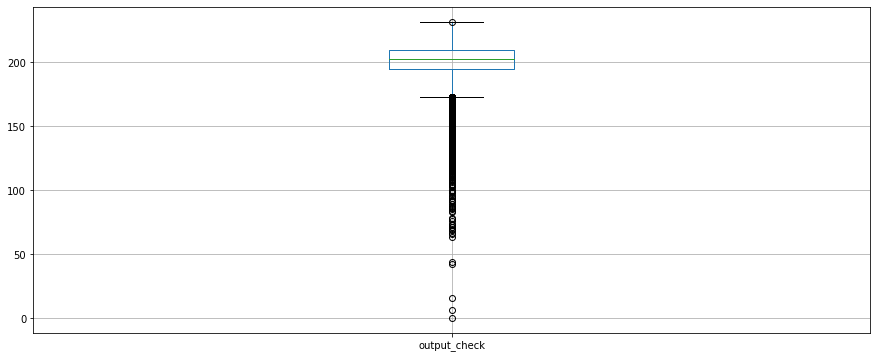

In [46]:
df_output_concentration_check.boxplot('output_check', figsize=(15, 6))

Верхний ус в районе 230, нижний ус в районе 175. Множественные выбросы - длинный хвост слева на гистограмме.

#### - выведем цифровые значения для выборок

In [47]:
df_output_concentration_check.describe().T

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,16094.0,5.190976,1.333257,0.0,4.277722,5.083578,5.894149,16.001945
final.output.concentrate_pb,16094.0,9.997593,1.568785,0.0,9.103183,10.092386,11.030644,17.031899
final.output.concentrate_sol,16094.0,9.871835,2.754533,0.0,8.156531,9.618630,11.324848,19.615720
final.output.concentrate_au,16094.0,44.307437,4.210135,0.0,43.431184,44.986391,46.253912,51.571885
primary_cleaner.output.concentrate_ag,16094.0,8.674853,1.944943,0.0,7.531083,8.723466,9.955605,15.005789
primary_cleaner.output.concentrate_pb,16094.0,9.884018,2.402325,0.0,8.822906,10.182557,11.399084,17.081278
primary_cleaner.output.concentrate_sol,16094.0,10.747844,3.820215,0.0,8.140648,10.656540,13.639475,22.458114
primary_cleaner.output.concentrate_au,16094.0,32.065559,5.205760,0.0,30.299696,32.643752,34.828516,45.933934
rougher.output.concentrate_ag,16094.0,12.084945,2.697948,0.0,10.664288,12.232367,13.835104,21.725695
rougher.output.concentrate_pb,16094.0,7.553095,1.688073,0.0,6.696978,7.698308,8.510786,12.702148


In [48]:
df_input_concentration_check.describe().T

,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_ag,16094.0,8.985281,1.910084,0.01,7.426978,8.882196,10.398254,14.596026
rougher.input.feed_pb,16094.0,3.636621,1.041859,0.01,2.928259,3.572770,4.272312,7.142594
rougher.input.feed_sol,16094.0,36.962618,4.874568,0.01,34.408814,37.272903,40.165076,53.477742
rougher.input.feed_au,16094.0,8.516990,1.828474,0.01,7.080266,8.366978,9.939579,13.731330
input_check,16094.0,58.101510,6.761203,0.04,54.363838,58.226620,62.578101,76.978947


1. В суммарном распределении есть множественные выбросы.
2. В датасете есть наблюдения с концентрацей всех веществ на разных стадиях - в сырье, в черновом и финальном концентратах - равным нулю или близким нулю (0.01). С некотрой осторожностью можно утверждать, что это пропущенные значения.
3. В отсутствие возможности уточнить информацию у поставщика сведений, принято решение удалить выбросы.

#### - удалим аномалии в исходном датасете, проверим размерность датасета

In [49]:
df_full['output_check'] = df_output_concentration_check['output_check']
df_full['input_check'] = df_input_concentration_check['input_check']

In [50]:
df_full = df_full.query('output_check > 160 and input_check > 40')

In [51]:
df_full.shape

(15252, 88)

&#9889; **Вывод:** удалены множественные выбросы в суммарном распределении веществ.

[Оглавление](#TOC)

# IV. Модель<a class='anchor' id='4'>
***

## 1. Инициализируем модели, создадим словарь для поиска наилучших параметров, разделим выборку на обучающую и тестовую в соотношении 75:25, выделим целевые признаки<a class="anchor" id="4_1">
***

In [52]:
models = []

#### - LinearRegression

In [53]:
lr = LinearRegression(n_jobs=-1)

param_grid={'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}

models.append(('lr', lr, param_grid))

#### - DecisionTreeRegressor

In [54]:
dtr = DecisionTreeRegressor(random_state=42, max_features='auto')

param_grid = {'max_depth': np.arange(10, 20)}

models.append(('dtr', dtr, param_grid))

#### - RandomForestRegressor

In [55]:
rfr = RandomForestRegressor(random_state=42, n_estimators=30, max_features='auto', n_jobs=-1)

param_grid = {'max_depth': np.arange(10, 20)}

models.append(('rfr', rfr, param_grid))

#### - разделим выборку на обучающую и тестовую в соотношении 75:25, выделим целевой признак

In [56]:
features = df_test.columns

In [57]:
df_train, df_test = train_test_split(df_full, test_size=0.25, random_state=42)

In [58]:
x_train = df_train[features]
x_test = df_test[features]

In [59]:
y_train_final = df_train['final.output.recovery']
y_train_rougher = df_train['rougher.output.recovery']
y_test_final = df_test['final.output.recovery']
y_test_rougher = df_test['rougher.output.recovery']

[Оглавление](#TOC)

## 2. Обучим модель, посчитаем метрику SMAPE<a class='anchor' id='4_2'>

#### - объявим функцию reporter, которая соберет отчет по метрикам для каждой из моделей

In [60]:
def reporter(models):
    report = []
    
    for model in models:
        final_grid = explorer.grid_search(model[1], model[2], 5, x_train, y_train_final)
        rougher_grid = explorer.grid_search(model[1], model[2], 5, x_train, y_train_rougher)

        predicted_final = list(final_grid.predict(x_test))
        predicted_rougher = list(rougher_grid.predict(x_test))

        smape_fin_concentrate = explorer.smape(y_test_final, predicted_final)
        smape_rough = explorer.smape(y_test_rougher, predicted_rougher)

        final_smape = 0.25*smape_rough+0.75*smape_fin_concentrate

        report.append((model[0], smape_fin_concentrate, smape_rough, final_smape, final_grid, rougher_grid))
       
    final_report = pd.DataFrame(report, columns=['Model', 'SMAPE for final concentrate', 'SMAPE for rougher', 'Final SMAPE', 'final_grid_params', 'rougher_grid_params'])
    
    return final_report

In [61]:
final_report = reporter(models)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


In [62]:
final_report[['Model', 'Final SMAPE']]

,Model,Final SMAPE
0,lr,5.911041
1,dtr,5.236478
2,rfr,4.206389


In [63]:
final_report

,Model,SMAPE for final concentrate,SMAPE for rougher,Final SMAPE,final_grid_params,rougher_grid_params
0,lr,6.599219,3.846509,5.911041,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr..."
1,dtr,6.043796,2.814522,5.236478,"DecisionTreeRegressor(criterion='mse', max_dep...","DecisionTreeRegressor(criterion='mse', max_dep..."
2,rfr,4.894272,2.142737,4.206389,"(DecisionTreeRegressor(criterion='mse', max_de...","(DecisionTreeRegressor(criterion='mse', max_de..."


[Оглавление](#TOC)

&#9889; **Вывод:** 

1. Обучено три модели - линейная регрессия, решающее дерево и случайный лес. Итоговый SMAPE для каждой из 
    - LinearRegression - 5.9
    - DecisionTreeRegressor - 5.24
    - RandomForestRegressor - 4.2
2. По метрике SMAPE наилучший результат показала модель случайный лес - RandomForestRegressor.
3. Параметры моделей и результаты сохранены в таблице final_report.


[Оглавление](#TOC)